# $k$ Nearest Neighbor
## Foundations of Machine Learning
## `! git clone https://www.github.com/DS3001/knn`

In [13]:
! git clone https://www.github.com/DS3001/knn

fatal: destination path 'knn' already exists and is not an empty directory.


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns

def pn(x):
    print(x,'\n')
    return

## Algorithms and Models
- The analysis we've done up to now is about cleaning and summarizing the properties of data
- We want to pivot to using the data to make predictions
- In machine learning, there are two key concepts:
  - *Algorithms*: A process that converts inputs into results
  - *Models*: A mathematical abstraction or simplification intended to mimic real phenomena
- **Machine learning**: *We (1) use algorithms to fit models to data, and then (2) use those fitted models to make predictions about future outcomes for new data*
- The goal is to produce a data-driven tool for predictive purposes
- There is a lot to learn, and the steps will become more natural as we fit and use more models

## Two Algorithmic Steps
- There's two steps: (1) Fitting the model and (2) Making the predictions
- We'll introduce the model by working backwards: Given a fitted model, how do you make predictions? Understanding how models work gives you insights into how to build them.
- With an understanding of how the model works, we'll then take a step back: How do you train/fit/tune/etc. the model? This is a *training algorithm* or *optimization algorithm*.
- In common practice, the difference between machine learning and statistics is that ML is focused on *prediction* and less on *inference* or *causality* --- the goal is to build predictive models, not estimate them and engage in *hypothesis testing* (unbiased/consistent estimates are not necessarily [often not] good predictive models)

## Data Examples
- Car Price (`USA_cars_datasets.csv`): Based on car attributes ($X$), predict its transaction price ($y\ge 0$)
- Heart Failure (`heart_failure_clinical_records_dataset.csv`): Based on patient characteristics ($X$), predict whether they die ($y=0,1$)

## Data in General
- We have a clean $N \times (M+1)$ matrix $D$ of data; rows $i$ are observations and columns $j$ are variables
- One variable is be the *target*, *dependent*, *outcome*, *prediction*, *labeled* variable, which is an $N \times 1$ vector $y$
- All the other variables are potential *feature*, *explanatory*, *independent*, *control*, *covariate*, *predictor* variables, which is an $N \times M$ matrix $X$
- We'll refer to the $i$-th row/observation of $X$ by $x_i$

## Euclidean Distance
- Distance is at the core of many of our models (kNN, kMC, kernel methods), so let's review the basic defintions before we start with kNN
- Take two numbers, like 5 and 7. What's the distance between them? You can start by subtracting them, but the order then seems to matter: $5-7=-2$ and $7-5=2$. So we square that difference, and then take the square root again to convert to the absolute value:
$$
d(z,w) = \sqrt{(z-w)^2} = |z-w|
$$
    - That gives us $\sqrt{(5-7)^2} = \sqrt{(-2)^2} = \sqrt{4}=2$.

## Euclidean Distance
- What about the distance between two vectors $z = (z_1, z_2, ..., z_L)$ and $w = (w_1, w_2, ..., w_L)$? For example, two rows of a dataframe?
- To measure the *(Euclidean) distance* between two vectors, we do "the same thing":
    1. For each dimension $1, 2, ..., L$, compute the squared difference, $(z_\ell-w_\ell)^2$
    2. Sum the squared differences, $S =(z_1-w_1)^2+ ... + (z_L-w_L)^2$
    3. Take the square root of the sum, $\sqrt{S}$
- More compactly:
$$
d(z,w) = \sqrt{\underbrace{(z_1-w_1)^2}_{\text{First Dimension}} + ... + \underbrace{(z_L-w_L)^2}_{\text{$L$-th Dimension}}} =  \sqrt{\sum_{\ell=1}^L (z_{\ell} - w_{\ell})^2} = ||z-w||
$$

## Example
- Take `z = (3,5,7)` and `w=(2,-4,6)`
- Then the squared differences are $(3-2)^2=1$, $(5--4)^2=81$, and $(7-6)^2=1$
- The sum is 83
- The square root is 9.110
```
np.sqrt((3-2)**2+(5--4)**2+(7-6)**2)
```

## Other Kinds of Distance
- There are many ways to think of the distance between two objects, and they all have strengths and weaknesses:
    - Sup/Max norm: $ d_\infty(z,w) = \max_{i} |z_i-w_i|$ is useful for worst-case situations
    - Euclidean norm: $ d_2(z,w) = \sqrt{\sum_{\ell=1}^L (z_{\ell} - w_{\ell})^2}$, the standard distance metric
    - Manhattan norm: $d_1(z,w) = \sum_{\ell=1}^L |z_\ell - w_\ell|$ is more robust to outliers than Euclidean
    - $p$-norm: $ d_p(z,q) = \left( \sum_{\ell=1}^L |z_\ell-w_\ell|^p \right)^{1/p}$ generalizes all the previous cases ($p=2$ for Euclidean, $p=\infty$ for max, $p=1$ for Manhattan)
- It often depends on context: How do you measure the social distance between people?

## k Nearest Neighbor
- The following claim seems reasonable: "Suppose that a target variable $y$ follows from features $x$. If $x$ and $x'$ are close together, then $y$ and $y'$ are probably also close together."
- If that's true, then making a prediction $\hat{y}$ for a new case $\hat{x}$ could be done by finding the values of $x$ in the data close to $\hat{x}$, and averaging those values
- We'll operationalize this idea more precisely in the subsequent slides

y        x1        x2  g
0 -0.589413 -0.749765  1.184519  a
1  2.375238  1.342680  1.937082  a
2  1.348009  2.153036  1.731000  a
3  1.279687  0.747564  2.361556  a
4  0.857518  1.981321  0.673762  a

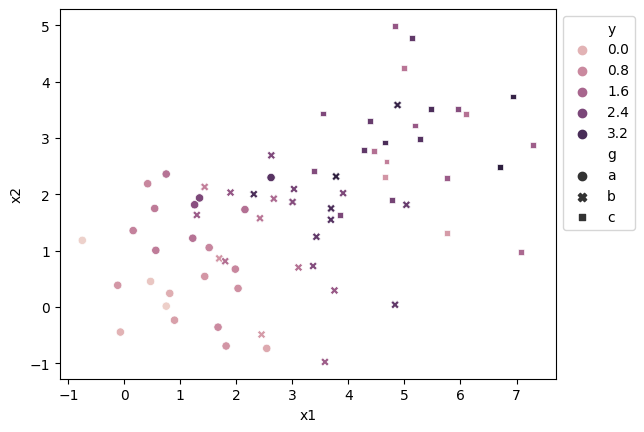

In [15]:
## Generate toy data:
np.random.seed(100) # Set the seed for replicability
N = 24  # Number of points
noise = 1/2  # Standard deviation of the shocks

# Generate (y,x1,x2) triples:
X1 = np.array([np.random.normal(1,1,N),np.random.normal(1,1,N)])
y1 = np.sum(X1,axis=0)/2+noise*np.random.normal(0,1,N)
X2 = np.array([np.random.normal(3,1,N),np.random.normal(2,1,N)])
y2 = np.sum(X2,axis=0)/2+noise*np.random.normal(0,1,N)
X3 = np.array([np.random.normal(5,1,N),np.random.normal(3,1,N)])
y3 = np.sum(X3,axis=0)/2+noise*np.random.normal(0,1,N)

gdf1 = pd.DataFrame({'y':y1,'x1':X1[0,:],'x2':X1[1,:],'g':'a'}) # Circles
gdf2 = pd.DataFrame({'y':y2,'x1':X2[0,:],'x2':X2[1,:],'g':'b'}) # Crosses
gdf3 = pd.DataFrame({'y':y2,'x1':X3[0,:],'x2':X3[1,:],'g':'c'}) # Squares

gdf = pd.concat([gdf1,gdf2,gdf3],axis=0) # Combine all data into one dataframe

this_plot = sns.scatterplot(data=gdf,x='x1',y='x2',hue='y',style='g') # Plot the fake data
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

gdf.head()

## Regression v. Classification
- In our toy data, the color represents $y$, a numeric variable. If we were using $(x_1, x_2)$ to predict a value $\hat{y}$, we would be performing **regression**: Predicting a numeric value for a new case
- In our toy data, the shape represents $g$, a categorical variable. If we were using $(x_1,x_2)$ to predict a value $\hat{g}$ from $\{a,b,c\}$, we would be performing **classification**: Predicting a categorical variable for a new case
- This is a significant distinction, especially later on when we start talking about how to evaluate models (regression will focus on metrics like $R^2$ or $RMSE$ based on the sum of squared error, while classification will focus on measures like Accuracy and Sensitivity based on the confusion matrix)

## $k$ Nearest Neighbor Prediction Algorithm (Regression)
- Consider a new case $\hat{x} = (\hat{x}_1,...,\hat{x}_L)$. We want to make a guess of what value it will likely take, $\hat{y}$, given existing data $D = (X,y)$
- Suppose the outcome variable $y$ is numeric: Price, weight, time, decibels, etc.
- The *$k$ Nearest Neighbor Algorithm* is:
  1. Compute the distance from $\hat{x}$ to each observation $x_i$
  2. Find the $k$ "nearest neighbors" to $\hat{x}$ in the data with the smallest distances from $\hat{x}$ to $x_i$, with outcomes $y_{1}^*$, $y_2^*$, ..., $y_K^*$
  3. Compute the average nearest neighhor outcome as the prediction for $\hat{x}$:
$$
  \hat{y} = \dfrac{y_1^* + y_2^* + ... + y_K^* }{K} =  \dfrac{1}{K} \sum_{k=1}^K y_k^*
$$


In [16]:
# A simple implementaton of kNN for regression:
def knn_hat(x_hat,gdf,k):
    # Compute distances between x_hat and the data:
    squared_difference = (x_hat - gdf.loc[:,['x1','x2']])**2
    distances = np.sum( squared_difference , axis = 1)
    # Find k smallest values in dist:
    neighbors = np.argsort(distances)[:k].tolist()
    # Find y values for the nearest neighbors:
    y_star = gdf['y'].iloc[neighbors].tolist()
    # Average neighbor values to get prediction:
    y_hat = np.mean(y_star)
    # Return a dictionary of computed values of interest:
    return({'y_hat':y_hat, 'y_star':y_star, 'neighbors':neighbors})

In [17]:
# Example:
x_hat = np.array((1,1)) # Example prediction case
knn = knn_hat(x_hat, gdf, 3) # Call our function
pn(knn['neighbors'])
pn(knn['y_star'])
pn(knn['y_hat'])

[6, 18, 5] 

[1.2762213728051925, 1.0911089111060162, 0.8709812459416442] 

1.0794371766176176 



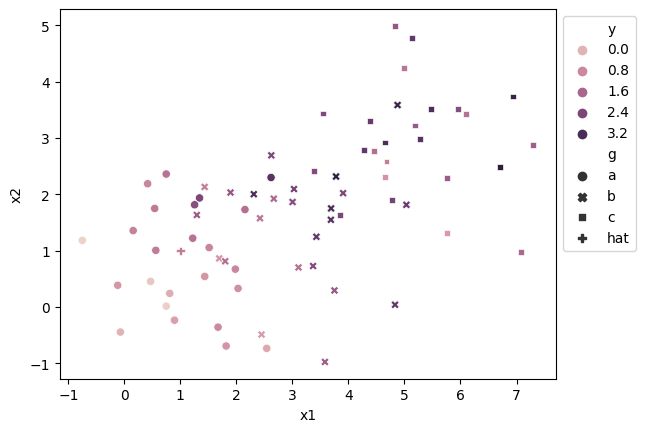

In [18]:
gdf2 = gdf
hat_row = [knn['y_hat'], x_hat[0], x_hat[1],'hat']
gdf2.loc[len(gdf2)] = hat_row
this_plot = sns.scatterplot(data=gdf2,x='x1',y='x2',hue='y',style='g') # Plot the fake data
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

## SciKit-Learn
- Unless we are doing something tailored to a particular task, we generally don't want to code our own algorithms: It is time consuming, and existing implementations are probably more efficient than what we would create (but there is a lot of value in coding your own algorithms and estimators)
- The most popular Python machine learning library is called **SciKit-Learn**
- You typically import it as `from sklearn.<model class> import <model name>`, where `<model class>` is the set of related models and `<model name>` is the desired algorithm
    - For example, `from sklearn.neighbors import KNeighborsRegressor`
- The workflow with `sk` is that you use it to (1) create an untrained model object, (2) fit that object to the data, then (3) use the fitted object to make predictions

## Car Purchase Data (and the importance of feature scaling)
- The data include `Gender` as categorical, `Age` as numeric, `AnnualSalary` as numeric, and whether they bought a car as a dummy, `Purchased`
- The scatterplot is really helpful for thinking about what's happening in these data: Which variables are likely to be useful for computing a new car purchase?
- Even before we start using models, crosstabs and scatterplots and grouped descriptions can help us understand how variation in the data shapes outcomes
- ...are these data real? Maybe a brand new car?

   User ID Gender  Age  AnnualSalary  Purchased
0      385   Male   35         20000          0
1      681   Male   40         43500          0
2      353   Male   49         74000          0
3      895   Male   40        107500          1
4      661   Male   25         79000          0 

           User ID          Age   AnnualSalary    Purchased
count  1000.000000  1000.000000    1000.000000  1000.000000
mean    500.500000    40.106000   72689.000000     0.402000
std     288.819436    10.707073   34488.341867     0.490547
min       1.000000    18.000000   15000.000000     0.000000
25%     250.750000    32.000000   46375.000000     0.000000
50%     500.500000    40.000000   72000.000000     0.000000
75%     750.250000    48.000000   90000.000000     1.000000
max    1000.000000    63.000000  152500.000000     1.000000 



Gender     Female  Male
Purchased              
0             297   301
1             219   183

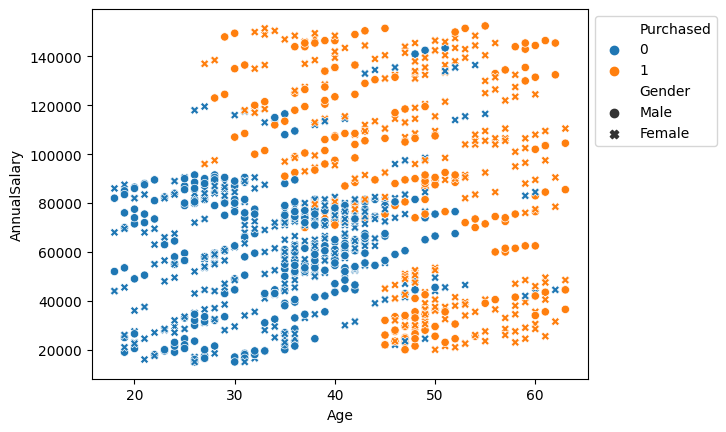

In [19]:
df = pd.read_csv('./knn/data/car_data.csv')
pn(df.head())
pn(df.describe())
this_plot = sns.scatterplot(data=df,x='Age',y='AnnualSalary',hue='Purchased',style='Gender')
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

# Gender doesn't look very predictive:
var = 'Purchased'
group = 'Gender'
df.loc[:,[var,group]].groupby(group).describe()
pd.crosstab(df[var],df[group])

## Fitting a Model with kNN
- To prepare to fit the model we have to do a few things:
    - Import the model we want to use: `from sklearn.neighbors import KNeighborsRegressor`
    - Create a matrix `X` of features and a vector `y` for the target variable
    - **Scale the features in `X` so their values are roughly comparable**
- Once we have our desired model imported and the data prepared as $D=(y,X)$, we can fit the model

## Feature/Variable Normalization/Scaling
- Problem: the distances in $k$NN depends on the "size/scale" of variables. Multiplying one variable by 10 or dividing by 100 (but not the others) will likely change your predictions
- Solution: We often **scale** or **normalize** variables to reduce the extent to which their relative values change the performance of the model
- There are a variety of approaches to this, but the simplest is **MaxMin Normalization**: For a vector $x$ and element $x_i$,
$$
u_i = \dfrac{x_i - \min(x)}{\max(x)-\min(x)}
$$
- You do not have to normalize the outcome variable, $y$, since we don't look at any distances related to $y$ in fitting or using the model (in some algorithms, you would want to)
- the max number is mapped to 1 and the min number is mapped to 0 in order to standardize the values

## The `.apply()` Method
- We'll make a maxmin scaler function:
```
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)
```
- But then we want to use it on each column of the data `X`
- Instead of a `for` loop, we can instead use the `df.apply(fcn)` method to apply the function `fcn` to each column
- If you want to use your function only on particular columns, you can use `df.loc[:,varList].apply(fcn)` instead

In [20]:
from sklearn.neighbors import KNeighborsRegressor as kNNRegression # Import the kNN regression tool

# Select features/target variable for analysis:
y = df['Purchased'] # Create target variable vector
X = df.loc[:,['Age','AnnualSalary']] # Create feature matrix
pn(X.head())
pn(X.describe())

# Maxmin normalization function:
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

# Apply maxmin to each column of X to get U:
X = X.apply(maxmin)
pn(X.head())
pn(X.describe())

# Fit the model:
k=3
model = kNNRegression(n_neighbors=k) # Create a sk model for k=3
fitted_model = model.fit(X,y) # Train the model on our data

   Age  AnnualSalary
0   35         20000
1   40         43500
2   49         74000
3   40        107500
4   25         79000 

               Age   AnnualSalary
count  1000.000000    1000.000000
mean     40.106000   72689.000000
std      10.707073   34488.341867
min      18.000000   15000.000000
25%      32.000000   46375.000000
50%      40.000000   72000.000000
75%      48.000000   90000.000000
max      63.000000  152500.000000 

        Age  AnnualSalary
0  0.377778      0.036364
1  0.488889      0.207273
2  0.688889      0.429091
3  0.488889      0.672727
4  0.155556      0.465455 

               Age  AnnualSalary
count  1000.000000   1000.000000
mean      0.491244      0.419556
std       0.237935      0.250824
min       0.000000      0.000000
25%       0.311111      0.228182
50%       0.488889      0.414545
75%       0.666667      0.545455
max       1.000000      1.000000 



## Prediction
- Now that we have a fitted model, we can make predictions with it
- You can pass dataframes of $\hat{x}$ values into the `.predict(x_hat)` method of a fitted model
- This returns a set of predictions $\hat{y}$
- Since the target variable `Purchased` is a dummy variable and takes the values 0 or 1, the predicted value is interpreted as a probability of making a purchase
- (I'm going to make a plot so we can visualize the performance of the kNN regression; no worries if you don't follow all the steps)

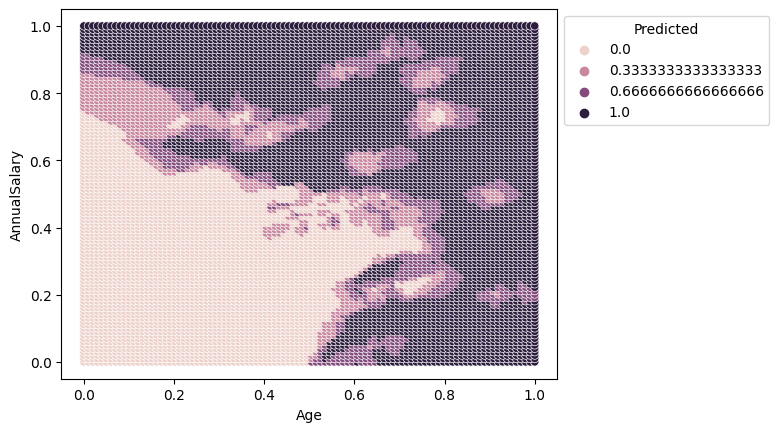

In [21]:
N_x = 100 # Coarseness of x variable
N_y = 100 # Coarseness of y variable
total = N_x*N_y # Total number of points to plot

grid_x = np.linspace(0,1,N_x) # Create a grid of x values
grid_y = np.linspace(0,1,N_y) # Create a grid of y values

xs, ys = np.meshgrid(grid_x,grid_y) # Explode grids to all possible pairs
X = xs.reshape(total) # Turns pairs into vectors
Y = ys.reshape(total) # Turns pairs into vectors

x_hat = pd.DataFrame({'Age':X,'AnnualSalary':Y}) # Create a dataframe of points to plot
y_hat = fitted_model.predict(x_hat) # Fit the model to the points
x_hat['Predicted'] = y_hat # Add new variable to the dataframe

this_plot = sns.scatterplot(data=x_hat,x='Age',y='AnnualSalary',hue='Predicted') # Create seaborn plot
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

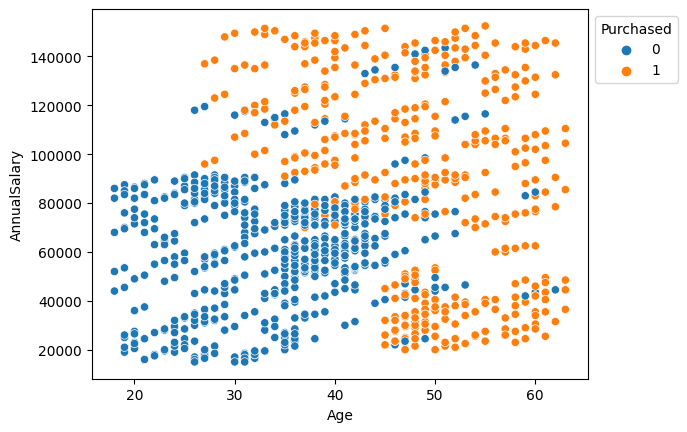

In [22]:
this_plot = sns.scatterplot(data=df,x='Age',y='AnnualSalary',hue='Purchased')
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

## Changing the number of neighbors
- We'll look at how to pick $k$ in a few slides
- Before we do that, how does the predictive model change as $k$ changes?
- Basically, the decision boundaries will get "softer" and the predictions will become less binary
- At some point, the model turns to mush: Instead of using local information, you're using "most of the data", and the predictions will tend towards the sample average of $.402$
- It is often useful to push models to extremes to see how they "break"
- **Underfitting** occurs when your model is too simple to reliably explain the phenomenon you are interested in, and **overfitting** occurs when your model is too complex to reliably explain the phenomenon you are interested in
- Notice the minimum and maximum predicted values in the legend, and the coarseness of the decision boundaries

In [23]:
def statics(k=3,data=df): # This function replicates our previous work, with k as an input
    y = df['Purchased'] # Create target variable vector
    X = df.loc[:,['Age','AnnualSalary']] # Create feature matrix
    # Normalize:
    X = X.apply(maxmin)
    model = kNNRegression(n_neighbors=k) # Create a sk model for k=3
    fitted_model = model.fit(X,y) # Train the model on our data
    N_x = 100 # Coarseness of x variable
    N_y = 100 # Coarseness of y variable
    total = N_x*N_y # Total number of points to plot
    grid_x = np.linspace(0,1,N_x) # Create a grid of x values
    grid_y = np.linspace(0,1,N_y) # Create a grid of y values
    xs, ys = np.meshgrid(grid_x,grid_y) # Explode grids to all possible pairs
    X = xs.reshape(total) # Turns pairs into vectors
    Y = ys.reshape(total) # Turns pairs into vectors
    x_hat = pd.DataFrame({'Age':X,'AnnualSalary':Y}) # Create a dataframe of points to plot
    y_hat = fitted_model.predict(x_hat) # Fit the model to the points
    x_hat['Predicted'] = y_hat # Add new variable to the dataframe
    this_plot = sns.scatterplot(data=x_hat,x='Age',y='AnnualSalary',hue='Predicted') # Create seaborn plot
    sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

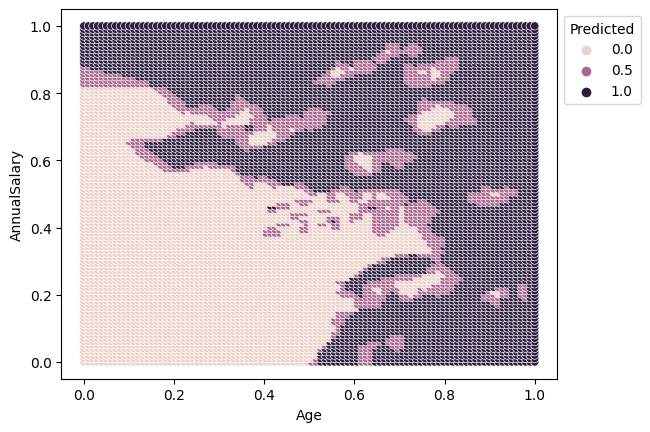

In [24]:
statics(2)

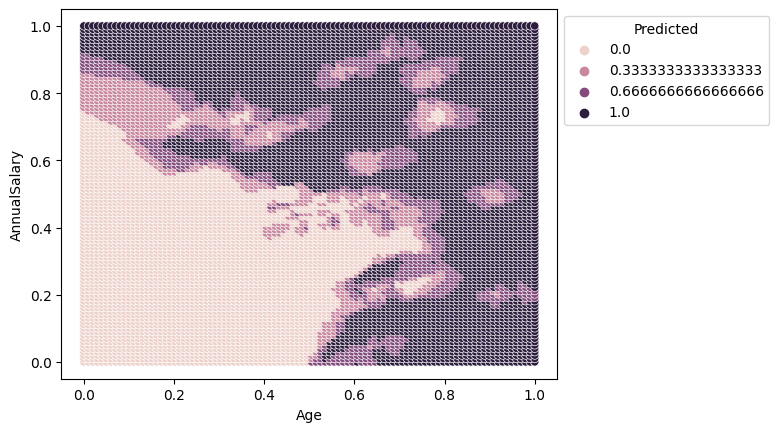

In [25]:
statics(3)

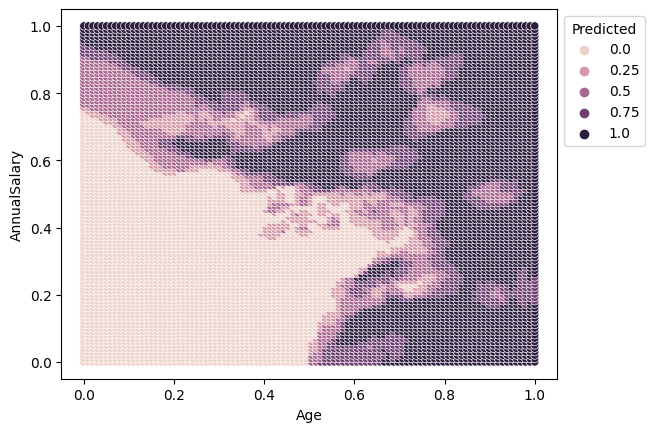

In [26]:
statics(4)

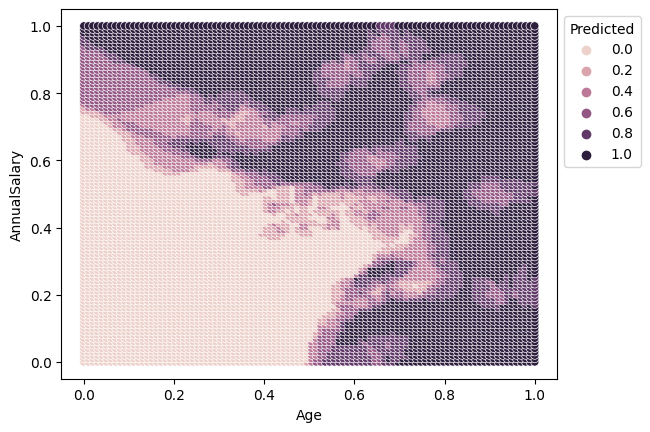

In [27]:
statics(5)

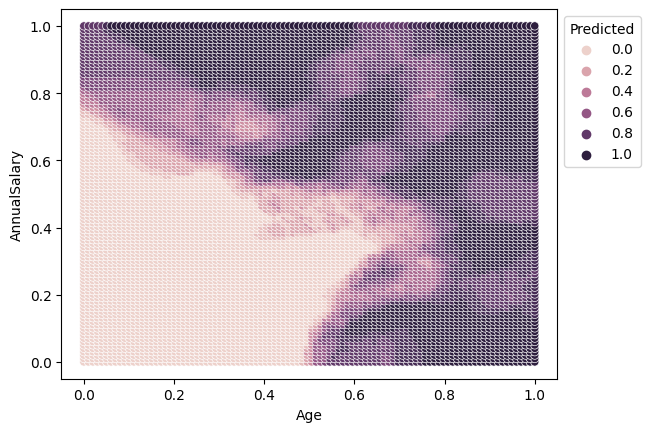

In [28]:
statics(10)

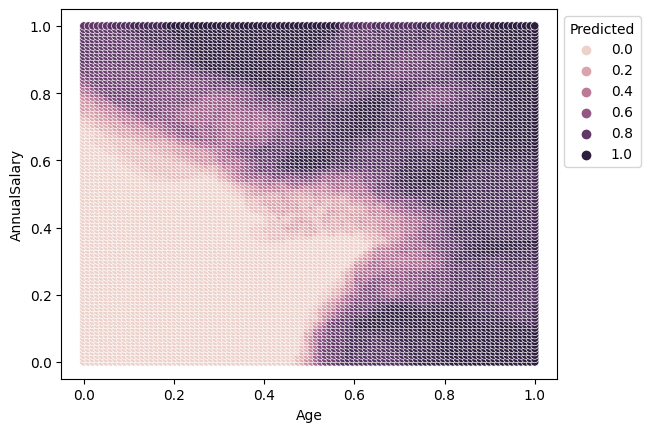

In [29]:
statics(20)

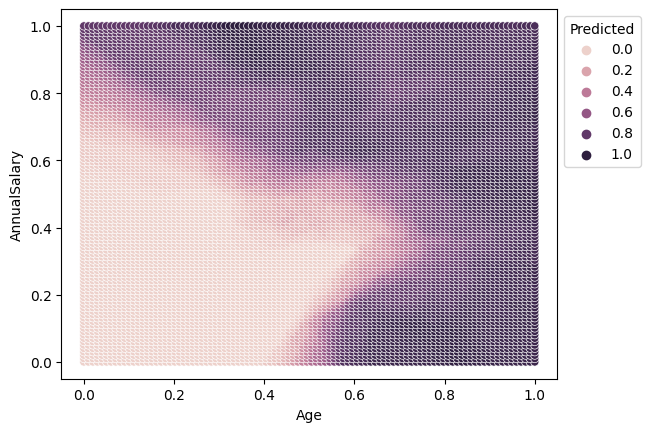

In [30]:
statics(50)

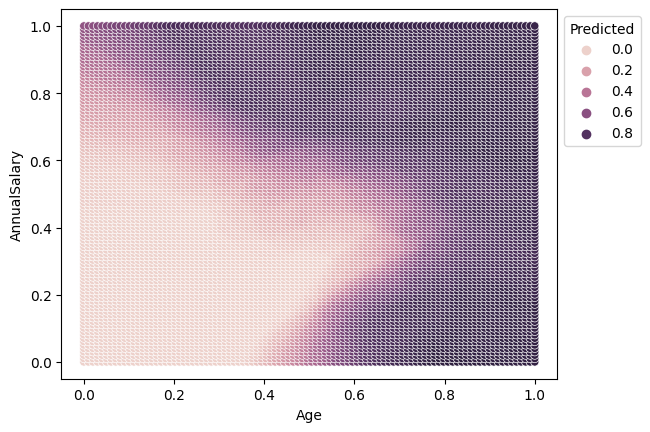

In [31]:
statics(100)

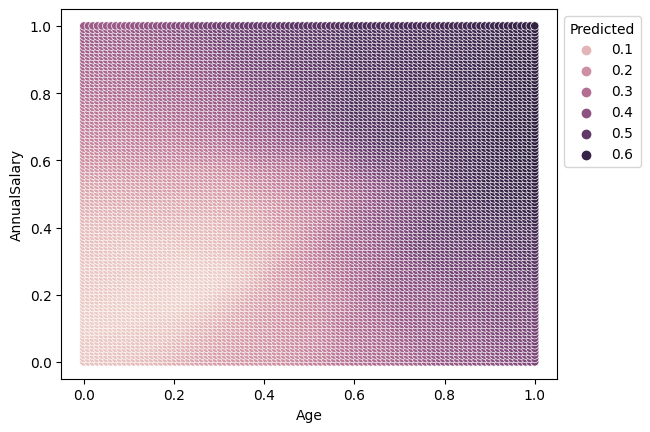

In [32]:
statics(500)

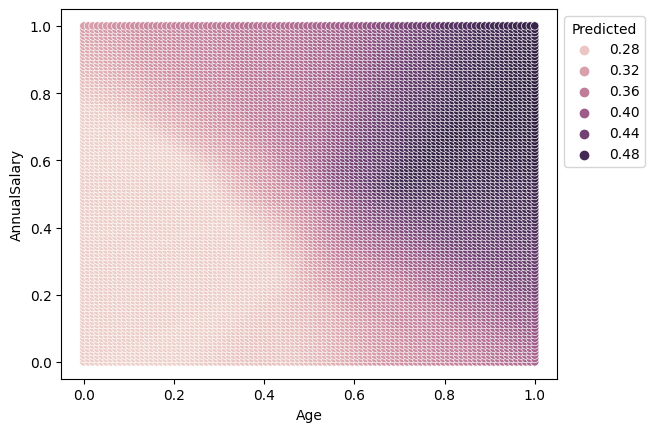

In [33]:
statics(800)

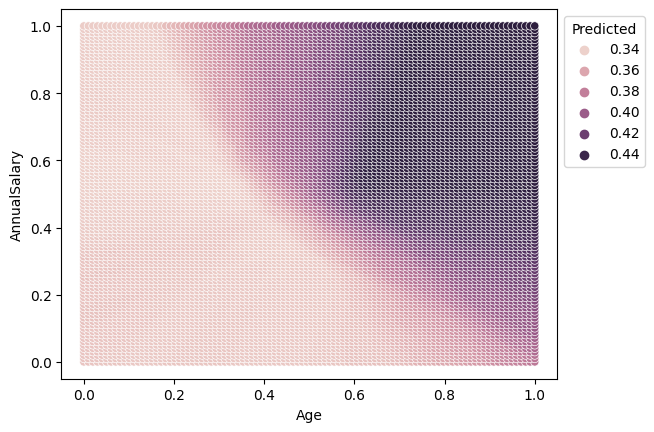

In [34]:
statics(900)

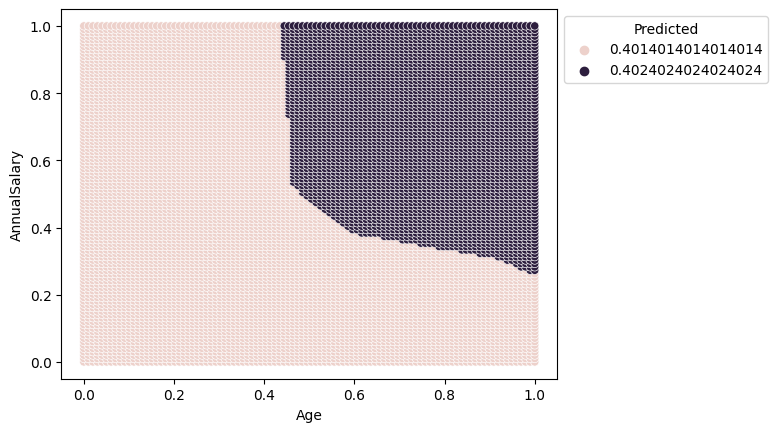

In [35]:
statics(999) # We're using 999/1000 points to predict values: This does not look reliable

## What happens if we fail to scale?
- Well, it doesn't "work", it looks really bad: This is an explanation of what not to do
- Since `AnnualSalary` is in tens of thousands and `Age` is in tens, we get "horizontal" equivalence classes of predictions that look nothing like the original picture, because the distance metric is "skewed" to think that people with similar Annual salaries are "more alike" than people with similar ages. But we want to use both dimensions somewhat equally.
- When using algorithms based on distance metrics, you really have to make sure that the way you conceive of "distance" across dimensions makes sense.
- (An alternative is using smoothing to weight neighbors, like a kernel density plot, rather than a hard boundary that picks specific neighbors, like a histogram.)

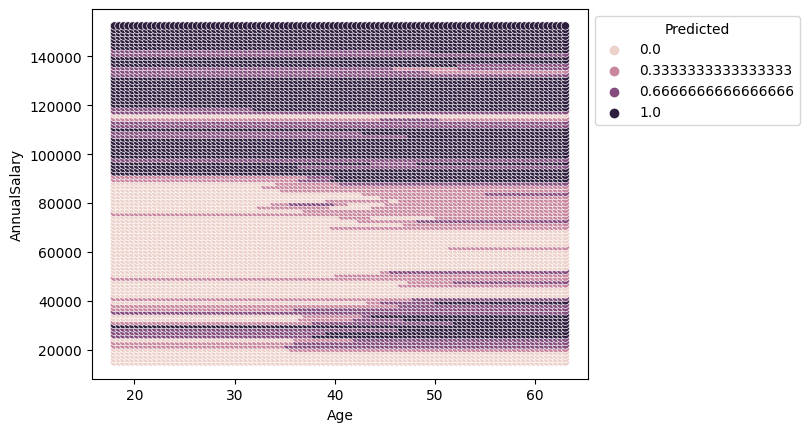

In [36]:
# Select features/target variable for analysis:
y = df['Purchased'] # Create target variable vector
X = df.loc[:,['Age','AnnualSalary']] # Create feature matrix
model = kNNRegression(n_neighbors=3) # Create a sk model for k=3
fitted_model = model.fit(X,y) # Train the model on our data

# Make a plot of the decision rule:
N_x = 100 # Coarseness of x variable
N_y = 100 # Coarseness of y variable
total = N_x*N_y # Total number of points to plot
xmin = np.min(X.iloc[:,0])
xmax = np.max(X.iloc[:,0])
ymin = np.min(X.iloc[:,1])
ymax = np.max(X.iloc[:,1])
grid_x = np.linspace(xmin,xmax,N_x) # Create a grid of x values
grid_y = np.linspace(ymin,ymax,N_y) # Create a grid of y values
xs, ys = np.meshgrid(grid_x,grid_y) # Explode grids to all possible pairs
X = xs.reshape(total) # Turns pairs into vectors
Y = ys.reshape(total) # Turns pairs into vectors
x_hat = pd.DataFrame({'Age':X,'AnnualSalary':Y}) # Create a dataframe of points to plot
y_hat = fitted_model.predict(x_hat) # Fit the model to the points
x_hat['Predicted'] = y_hat # Add new variable to the dataframe
this_plot = sns.scatterplot(data=x_hat,x='Age',y='AnnualSalary',hue='Predicted') # Create seaborn plot
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

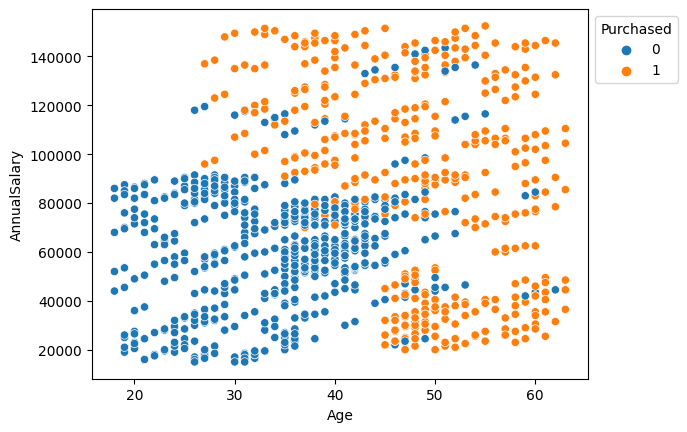

In [37]:
this_plot = sns.scatterplot(data=df,x='Age',y='AnnualSalary',hue='Purchased')
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

## What is a good fit?
- In machine learning, one of the main concerns is **external validity** or **generalizability**: Will the model perform well in practice, on data that it wasn't trained to fit?
- A heuristic/rule-of-thumb is $k^* = \lfloor \sqrt{N} \rfloor$. For the car purchase data, $k^*=31$. But this isn't really data-driven at all.
- There are roughly two concerns: Models will overutilize features of the data that might be specific to this data and not be present in the population overall, and model **hyper parameters** like $k$ will
- The simplest strategy is to **split the sample** into a training set (80% of the data) and a validation set (20% of the data), fit the model on the training data, and select hyperparameters and test on the validation set (validation set is like having a new set of data)
- As we go through the course, we'll add more sophisticated techniques like cross validation and bootstrap validation

## Fit and Sum of Squared Error
- What is a good fit?
- We usually have a distance metric in mind: "How far are the predictions from the true outcomes, on the validation/test set?"
- So for each observation $i$ in the validation set, we subtract the predicted value from the true one and square it, then sum over all the observations:
$$
SSE(k) = \sum_{i=1}^L (y_i - \hat{y}(x_i,k))^2
$$
- The $SSE(k)$ is a really common measure of how far the predicted values are from the true values

## Fitting the Model: Selecting $k$

- A simple and effective data-driven strategy is to randomly **split the data** into two sets, a **training set** and a **test/validation set**:
  - For a reasonable range of values $k = 1, 2, ..., \overline{K}$, we make a prediction using the training set and then test the performance on the validation set
  - Compute the distance from the prediction based on the training data to the true outcome in in the validation set for each point in the validation set, then average to get the *mean squared error (MSE)*
  - Pick the $k$ that achieves the lowest MSE
- The variable $k$ is our first example of a *hyperparameter*: The data themselves do not prescribe a value of $k$, and naive ways of picking it will lead to bad predictive models

## Splitting the Sample
- `sk` has a `.model_selection` module that contains a `train_test_split` function that makes it easy to split your data
- Once the data are split, we use a `for` loop to compute the SSE for the training and test data for each reasonable value of $k$

In [38]:
import matplotlib.pyplot as plt

y = df['Purchased'] # Create target variable vector
X = df.loc[:,['Age','AnnualSalary']] # Create feature matrix
X = X.apply(maxmin) # Normalize X

# Split the sample:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

# # If you wanted to split without sk:
# N = df.shape[0] # Total number of rows
# all_rows = np.arange(N) # Create a list of all row indices
# train_rows = np.random.choice(N,int(.8*N),replace=False) # Draw 80% of the rows for testing
# test_rows = list(set(all_rows)-set(train_rows)) # Find the remaining rows for training
# # Create train/test data:
# X_train = X.iloc[train_rows,:]
# y_train = y.iloc[train_rows]
# X_test = X.iloc[test_rows,:]
# y_test = y.iloc[train_rows]

k_bar = 70
k_grid = np.arange(1,k_bar)
SSE_train = np.zeros(k_bar)
SSE_test = np.zeros(k_bar)
for k in range(k_bar):
    model = kNNRegression(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train,y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test) # Predict values for test set
    SSE_test[k] = np.sum( (y_test-y_hat)**2 ) # Save the computed SSE
    y_hat = fitted_model.predict(X_train) # Predict values for training set
    SSE_train[k] = np.sum( (y_train-y_hat)**2 ) # Save the computed SSE

SSE_min = np.min(SSE_test) # Lowest recorded SSE
min_index = np.where(SSE_test==SSE_min) # Find the indices of y that equal the minimum
k_star = k_grid[min_index] # Find the optimal value of k
pn(k_star)

[9] 



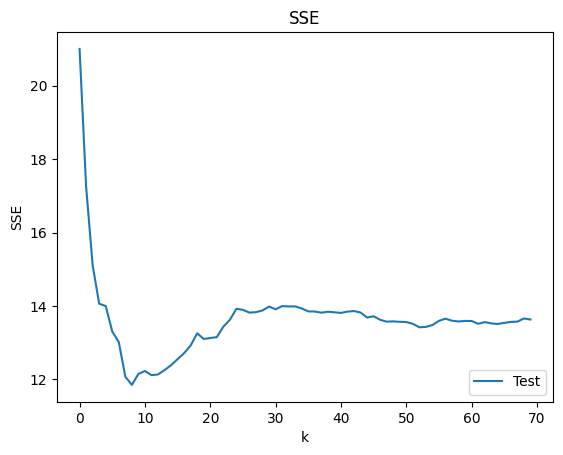

In [39]:
plt.plot(np.arange(0,k_bar),SSE_test,label='Test') # Plot SSE by k
plt.xlabel("k")
plt.ylabel("SSE")
plt.legend(loc='lower right')
plt.title('SSE')
plt.show()

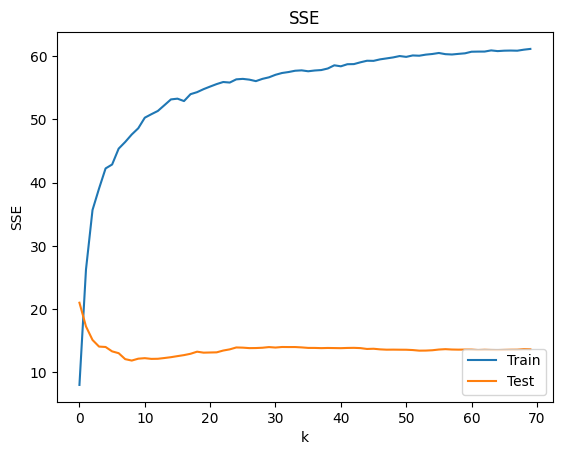

In [40]:
plt.plot(np.arange(0,k_bar),SSE_train,label='Train') # Plot SSE by k
plt.plot(np.arange(0,k_bar),SSE_test,label='Test') # Plot SSE by k
plt.xlabel("k")
plt.ylabel("SSE")
plt.legend(loc='lower right')
plt.title('SSE')
plt.show()

## Other Examples
- heart_failure.csv: `DEATH_EVENT` is that the patient died, and all of the other varibles are potential predictors
- USA_cars_datasets.csv: Price as a function of other characteristics

## Regression versus Classification
- Our first application --- purchase decisions from consumer characteristics --- was a *regression* problem: Predicting a numeric or continuous value, namely a probability
- Our next application is *classification*: Predicting which values are most likely when the outcome is categorical
- For example, instead of predicting the price of a vehicle, the goal might be to predict the make/model based on characteristics like price, engine size, fuel economy, number of doors, etc.

## Classification Example
- To illustrate how classification works, we are going to predict gender from age and annual salary
- This is a classification problem because the `Male` and `Female` coding in the data is not inherently numeric in any way: They're just broad categories that cannot be "ranked" or meaningfully given units.
- Notice, there's no reason you would think that car sales data could inform you about this question, and yet, it works really well. Useful data often live in unexpected places.
- With classification, the goal is to either the probability that the new case will belong to each category (or make a single one-shot prediction)

## $k$ Nearest Neighbor Prediction Algorithm (Classification)
- Consider a new observation $\hat{x}$. We want to make a guess of what value it will likely take, $\hat{y}$, given existing data $D = (X,y)$
- Suppose the $y$ variable is *categorical* with $J$ categories: let $y_{ij}$ take the value 1 if $i$ is in the $j$-th category
- The **$k$ Nearest Neighbor Algorithm** is:
  1. Compute the distance from $\hat{x}$ to $x_i$ for each observation $i$ in the data
  2. Find the $k$ "nearest neighbors" to $\hat{x}$ in the data with the smallest distances from $\hat{x}$ to $x_i$, with outcomes $y_{1j}^*$, $y_{j2}^*$, ..., $y_{jk}^*$ for each $j$
  3. Compute the probability that $\hat{y}$ takes each value $j=1,...,J$ as:
$$
\hat{y}_j = \dfrac{y_{1j}^*+y_{2j}^*+...+y_{kj}^*}{k}  = \dfrac{1}{K} \sum_{\ell=1}^K y_{\ell j}^*
$$

## Converting String-Categorical to Numeric-Categorical
- The `sk` libraries do not like string categories: You must ultimately convert everything into a numeric form to use `sk` (some packages or software make assumptions about string fields that make analysis a little easier, but this kind of discipline helps you avoid mistakes)
- To convert a string categorical to a numeric representation for variable `var`,
    1. Use `string_categories = df[var].unique()` to determine the unique values for `var`
    2. Use `df[var].replace(string_categories,np.arange(len(string_categories))` to convert each category to a number
        - Or do it by hand: e.g. `df['Gender'].replace(['Male','Female'],[0,1])`
- This will work when you have many categories (e.g. make/model of the car purchased)

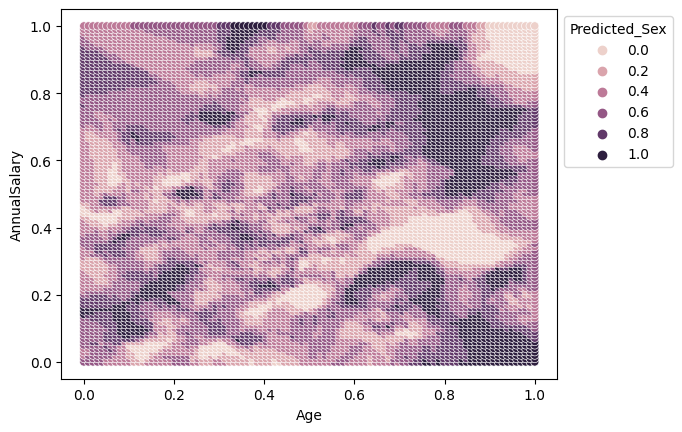

In [ ]:
from sklearn.neighbors import KNeighborsRegressor as kNNClassifier # Import the kNN classifier tool

# Select features/target variable for analysis:
y = df['Gender'].replace(['Male','Female'],[0,1]) # Create target variable vector
#or you can do it this way
# gen_cat = df['Gender'].unique()
# y = df['Gender'].replace(gen_cat, np.arange(len(gen_cat)))
X = df.loc[:,['Age','AnnualSalary']] # Create feature matrix

# Max-min normalize the features:
X = X.apply(maxmin)

# Fit the model:
model = kNNClassifier(n_neighbors=5) # Create a sk model for k=3
classifier_model = model.fit(X,y) # Train the model on our data

# Graph of predictor:
N_x = 100 # Coarseness of x variable
N_y = 100 # Coarseness of y variable
total = N_x*N_y # Total number of points to plot
grid_x = np.linspace(0,1,N_x) # Create a grid of x values
grid_y = np.linspace(0,1,N_y) # Create a grid of y values
xs, ys = np.meshgrid(grid_x,grid_y) # Explode grids to all possible pairs
X = xs.reshape(total) # Turns pairs into vectors
Y = ys.reshape(total) # Turns pairs into vectors
x_hat = pd.DataFrame({'Age':X,'AnnualSalary':Y}) # Create a dataframe of points to plot
y_hat = classifier_model.predict(x_hat) # Fit the model to the points
x_hat['Predicted_Sex'] = y_hat # Add new variable to the dataframe
this_plot = sns.scatterplot(data=x_hat,x='Age',y='AnnualSalary',hue='Predicted_Sex') # Create seaborn plot
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

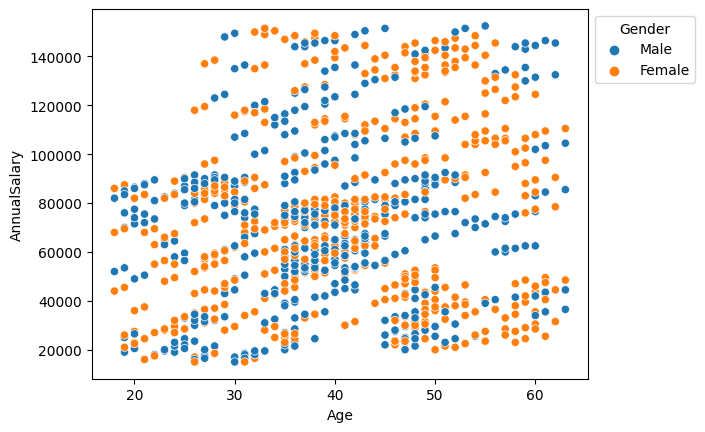

In [ ]:
this_plot = sns.scatterplot(data=df,x='Age',y='AnnualSalary',hue='Gender')
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

## Issues with $k$NN
- This is a purely inductive/blackbox prediction algorithm: We find the $k$ cases that are "most similar" to $\hat{x}$ in terms of distance, and guess the average of the outcomes for those points
- The choice of $d$ is crucial but apparently arbitrary
- For regression, it returns a *point prediction*, $\hat{y}$, and we might want to allow for more uncertainty in our predictions
- It is unclear how to interpret the impact of individual variables on predictions because of the local smoothing
- The local smoothing is "hard" like a histogram and not "smooth" like a kernel density; this leads to instability in predictions

## Main Take-aways
- Euclidean Distance
- Regression versus Classification
- Feature Scaling/Normalization
- Underfitting/Overfitting
- Splitting the Sample and Hyperparameter Fitting
- Sum of Squared Error
- kNN regression and classification
- The `.apply(fcn)` method